In [29]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import nltk
import re

In [2]:
twenty_all = fetch_20newsgroups(subset='all', shuffle=True)

# Data Preprocessing

* Cleaning alphanumeric symbols with regular expresions
* Removing stopwords
* Applying stemming


In [3]:
def process_data(dataset):
    stemmer = PorterStemmer()
    data = list()
    
    for article in tqdm(dataset.data):
        article = re.sub(r'[^\w]', ' ', article).strip()
        filtered_article = [stemmer.stem(word) for word in word_tokenize(article) if not word in stopwords.words('english')]
        new_article = ''
        
        for filtered_word in filtered_article:
            new_article += filtered_word + ' '
            
        data.append(new_article)
        
    dataset.data = data
    
    return dataset

In [4]:
twenty_all = process_data(twenty_all)

100%|██████████| 18846/18846 [07:35<00:00, 41.40it/s]


# Creating Pipelines and Models

* Applying bag of words
* Applying TF + IDF transformation
* Creating different models: MultinomialNB, Random Forest, SGD, KNN
* Checking models' accuracy using cross validation


In [5]:
#MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
scores = cross_val_score(text_clf, twenty_all.data, twenty_all.target, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.86551724 0.87980897 0.8742372  0.8694614  0.86442027]
Mean Score 0.870689014739115


In [6]:
#KNN Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_jobs=-1)),
])
scores = cross_val_score(text_clf, twenty_all.data, twenty_all.target, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.8066313  0.81453967 0.81268241 0.81480499 0.80631467]
Mean Score 0.8109946069886051


In [7]:
#SGD Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(n_jobs=-1)),
])
scores = cross_val_score(text_clf, twenty_all.data, twenty_all.target, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.92122016 0.9265057  0.92570974 0.91828071 0.91642345]
Mean Score 0.9216279532948182


In [8]:
#Random Forest Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_jobs=-1)),
])
scores = cross_val_score(text_clf, twenty_all.data, twenty_all.target, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.85835544 0.86017511 0.86335898 0.85327673 0.85539931]
Mean Score 0.8581131145960379


# Checking Models' Accuracy on Training and Testing Datasets

In [9]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

In [10]:
twenty_train = process_data(twenty_train)
twenty_test = process_data(twenty_test)

100%|██████████| 7532/7532 [02:40<00:00, 47.04it/s]


In [48]:
#Train Random Forest Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_jobs=-1, random_state=42)),
])
forest = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = forest.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7778810408921933

In [12]:
#Train SGD Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, n_iter_no_change=5, random_state=42, n_jobs=-1)),
])
sgd = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = sgd.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.8513011152416357

In [47]:
#Train Multinomial NB Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
bayes = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = bayes.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.8041688794476899

# Confusion Matrix Visualization
* Using seaborn heatmap to visualize final model's performances

In [22]:
sgd_prediction = sgd.predict(twenty_test.data)
forest_prediction = forest.predict(twenty_test.data)
bayes_prediction = bayes.predict(twenty_test.data)

In [41]:
sgd_cf = confusion_matrix(sgd_prediction, twenty_test.target)
forest_cf = confusion_matrix(forest_prediction, twenty_test.target)
bayes_cf = confusion_matrix(bayes_prediction, twenty_test.target)

categories = list(twenty_test.target_names)

<AxesSubplot:>

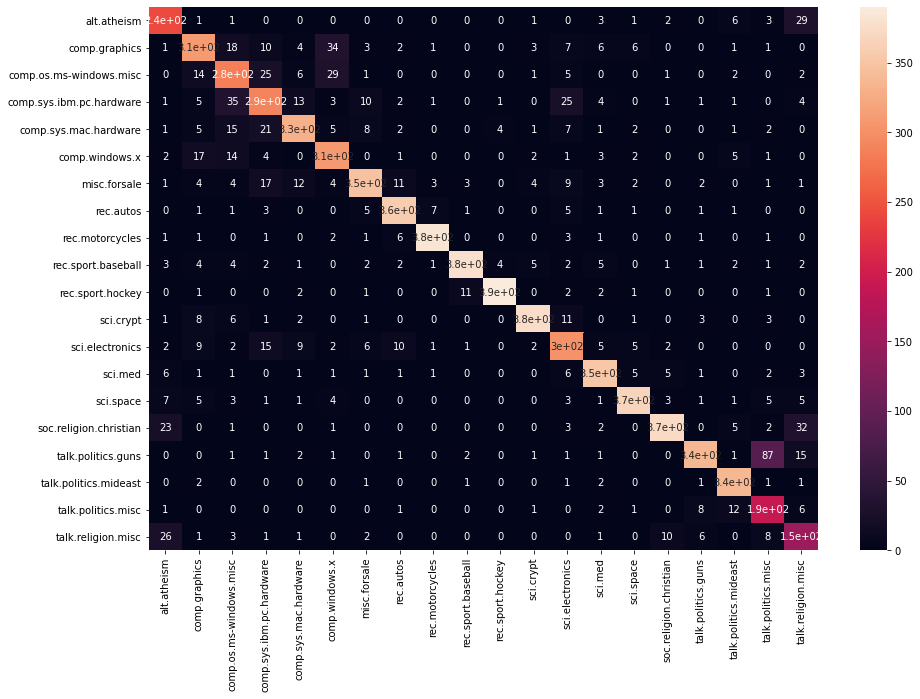

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(sgd_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**SGD Classifier** confusion matrix shows a very good performance in all categories.

<AxesSubplot:>

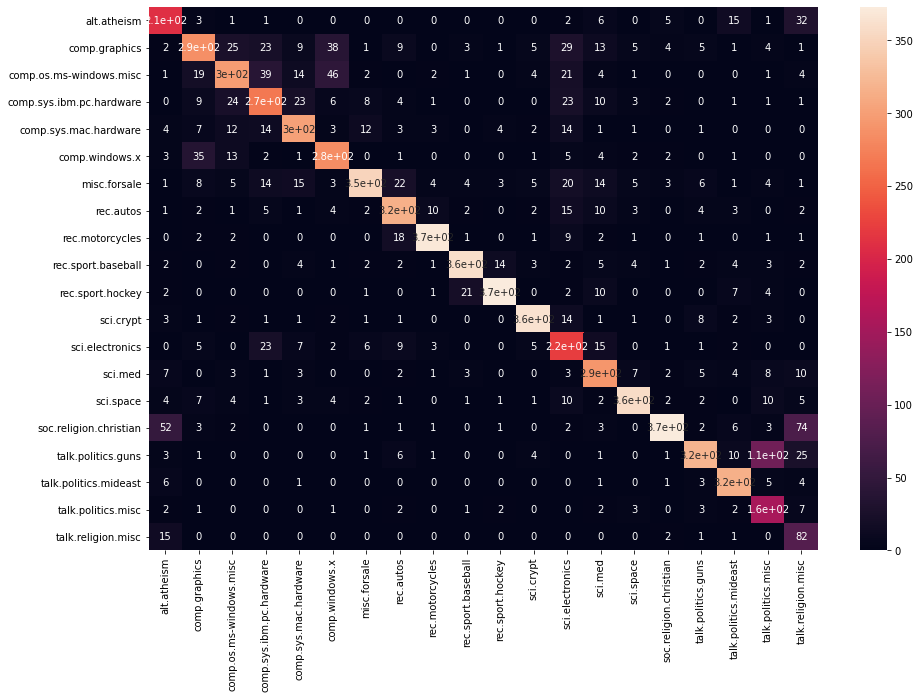

In [50]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(forest_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**Random Forest Classifier's** confusion matrix shows a very poor performance in **talk.politics.misc** category. In a lot of cases, this category is classified as **talk.politics.guns**.

<AxesSubplot:>

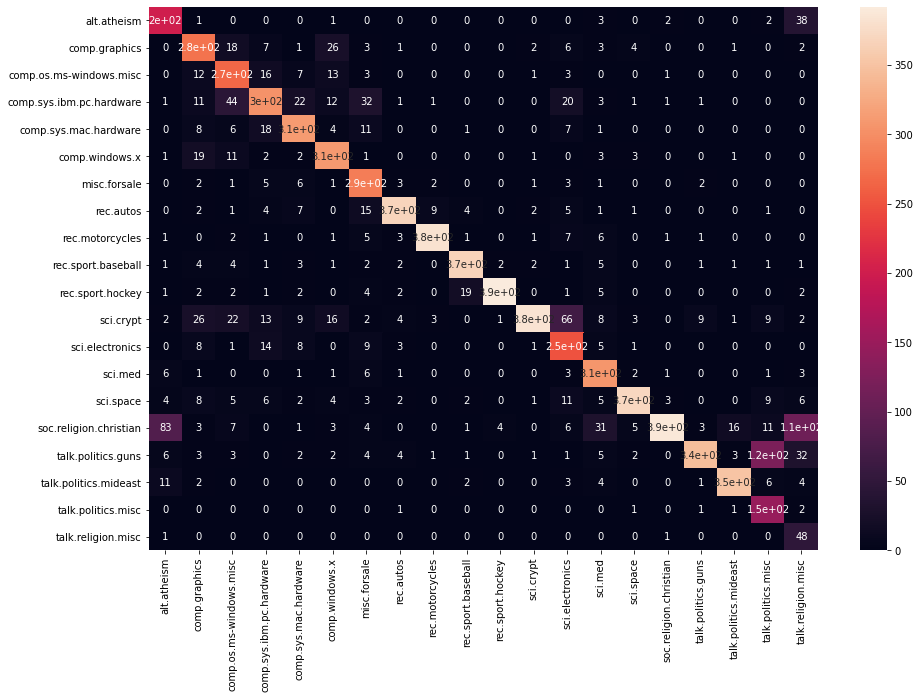

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(bayes_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**MultinomialNB's** confusion matrix shows a very poor performance in **talk.politics.misc** and **talk.religion.misc** categories. In a lot of cases, these categories are classified as **talk.politics.guns** and **soc.religion.christian**.

# Conclusion

Without too much hyperparameter fine tunning, **SGD Classifier** is the best model so far with an accuracy of **85.13%**.
I have also tried **MultinomialNB** and **Random Forest Classifier** but their accuracy is much lower: **80.41%** and **77.77%**.